<a href="https://colab.research.google.com/github/jesobole/OTD/blob/main/GINI_and_EFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [343]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import math
from scipy import stats
import os
import random

np.random.seed(0)
random.seed(10)

In [344]:
#Define context generating function.
gender_pdf = np.array([0.5, 0.5])#marginal distribution of gender. [male, female]
location_pdf = np.array([0.22, 0.46, 0.32])#marginal distribution of city level. [large city, medium city, small city]
age_seg_pdf = np.array([0.46, 0.34, 0.20])#marginal distribution of age. [small age, middle age, large age]
dim_context  = int(np.shape(gender_pdf)[0]+np.shape(location_pdf)[0]+np.shape(age_seg_pdf)[0])

def context_generate(gender_ratio = gender_pdf, loc_ratio = location_pdf, age_ratio = age_seg_pdf):
    a = np.random.multinomial(1, gender_pdf, size=1)
    b = np.random.multinomial(1, location_pdf, size=1)
    c = np.random.multinomial(1, age_ratio, size=1)
    return np.concatenate((a, b, c), axis=None)
context_generate(gender_ratio = gender_pdf, loc_ratio = location_pdf, age_ratio = age_seg_pdf)

array([1, 0, 0, 0, 1, 1, 0, 0])

In [345]:
# hyperparameters settings. Notice that this system is based on first price auction and CPC,
# which are consistent with paper modeling assumption in Section 3
import sys
sys.argv=['']
del sys
parser = argparse.ArgumentParser()

parser.add_argument('--total_ads', type=int, default=10, help='total number of ads for simulation')
parser.add_argument('--total_slots', type = int, default= 5, help='number of slots' )

opt = parser.parse_args()


In [346]:
def generate_ads(n, dim_context = dim_context):
    #n is the total number of ads

    #initialize output data:
    coefficient_ctr_model = np.zeros([n, dim_context])

    budgets = np.zeros(n)

    #generate bid, true CTR model
    for i in range(n):
        coefficient_ctr_model[i, :] = np.random.uniform(0,0.05,dim_context)
        budgets[i] = np.random.uniform(0.01, 1)

    return budgets, coefficient_ctr_model

budgets, coefficient_ctr_model = generate_ads(n = opt.total_ads, dim_context = dim_context)


In [260]:
budgets

array([0.54121342, 0.38962926, 0.69061339, 0.43043861, 0.71969108,
       0.75117698, 0.02626533, 0.87774019, 0.30009008, 0.64307779])

In [261]:
pi_context = np.random.uniform(1, 10, dim_context)
pi_context = pi_context/np.sum(pi_context)
pi_context

array([0.11694158, 0.06046092, 0.22750518, 0.07336865, 0.15173778,
       0.08177163, 0.05093979, 0.23727448])

In [262]:
def positional_discounts(k = opt.total_slots):
  return np.array([(1 - (i/k)**2) for i in range(k)])

positional_discounts(opt.total_slots)


array([1.  , 0.96, 0.84, 0.64, 0.36])

In [301]:
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

n = opt.total_ads
m = dim_context
gamma_vec = positional_discounts(opt.total_slots)
k = opt.total_slots
#bounds
bounds = Bounds(np.zeros(n*m), np.ones(n*m))

#linear constrains
A = np.zeros([m, n*m])
for i in range(m):
  A[i, i * n: n * (i + 1)] = np.ones(n)
b_right = np.ones(m) * np.sum(gamma_vec)
b_left = np.zeros(m)

linear_constraint = LinearConstraint (A, b_left, b_right)

#efficiency alpha_vec = (alpha11,alpha12,alpha13,alpha21,alpha22,...)
def efficiency(alpha_vec, pi_vec = pi_context, ctr_mat = coefficient_ctr_model, n = opt.total_ads, m = dim_context, budget_vec = budgets):
  alpha_mat = alpha_vec.reshape(m,n).transpose()
  return (np.sum(alpha_mat * ctr_mat * pi_vec))

def gmd_kv(alpha_vec, pi_vec = pi_context, ctr_mat = coefficient_ctr_model,
           n = opt.total_ads, m = dim_context, budget_vec = budgets):
  gmd = 0
  alpha_mat = alpha_vec.reshape(m,n)
  for i in range(m):
    for j in range(n):
      for h in range(n):
        gmd += pi_vec[i]*(alpha_mat[i,j]*ctr_mat[j,i]/budget_vec[j] - alpha_mat[i,h]*ctr_mat[h,i]/budget_vec[h])**2
  return gmd

def target_func(alpha_vec, lam = 0):
  return lam * gmd_kv(alpha_vec) - efficiency(alpha_vec)


In [308]:
from scipy.optimize import minimize
lam = 10
alpha_vec0 = np.zeros(m*n)
res = minimize(target_func, alpha_vec0, tol=1e-5, constraints=[linear_constraint],bounds=bounds, args=10 )

In [298]:
res.x.reshape(m,n).transpose()
gmd_kv(res.x)

0.006158307142758893

In [309]:
gmd_kv(res.x)

0.0009327983149375964

In [310]:
efficiency(res.x)

0.06632856901475738

In [315]:
import matplotlib.pyplot as plt
x_gini = np.array([])
y_eff = np.array([])

for lam in np.arange(0, 10, 1):
  alpha_vec0 = np.zeros(m*n)
  res = minimize(target_func, alpha_vec0, tol=1e-5, constraints=[linear_constraint],bounds=bounds, args = lam)
  x_gini = np.append(x_gini, gmd_kv(res.x))
  y_eff = np.append(y_eff, efficiency(res.x))


In [317]:
for lam in np.arange(0, 1, 0.1):
  alpha_vec0 = np.zeros(m*n)
  res = minimize(target_func, alpha_vec0, tol=1e-5, constraints=[linear_constraint],bounds=bounds, args = lam)
  x_gini = np.append(x_gini, gmd_kv(res.x))
  y_eff = np.append(y_eff, efficiency(res.x))

In [319]:
for lam in np.arange(0, 0.1, 0.01):
  alpha_vec0 = np.zeros(m*n)
  res = minimize(target_func, alpha_vec0, tol=1e-5, constraints=[linear_constraint],bounds=bounds, args = lam)
  x_gini = np.append(x_gini, gmd_kv(res.x))
  y_eff = np.append(y_eff, efficiency(res.x))

In [321]:
for lam in np.arange(0, 0.01, 0.001):
  alpha_vec0 = np.zeros(m*n)
  res = minimize(target_func, alpha_vec0, tol=1e-5, constraints=[linear_constraint],bounds=bounds, args = lam)
  x_gini = np.append(x_gini, gmd_kv(res.x))
  y_eff = np.append(y_eff, efficiency(res.x))

In [323]:
for lam in np.arange(0, 0.001, 0.0001):
  alpha_vec0 = np.zeros(m*n)
  res = minimize(target_func, alpha_vec0, tol=1e-5, constraints=[linear_constraint],bounds=bounds, args = lam)
  x_gini = np.append(x_gini, gmd_kv(res.x))
  y_eff = np.append(y_eff, efficiency(res.x))

Text(0, 0.5, 'Efficiency')

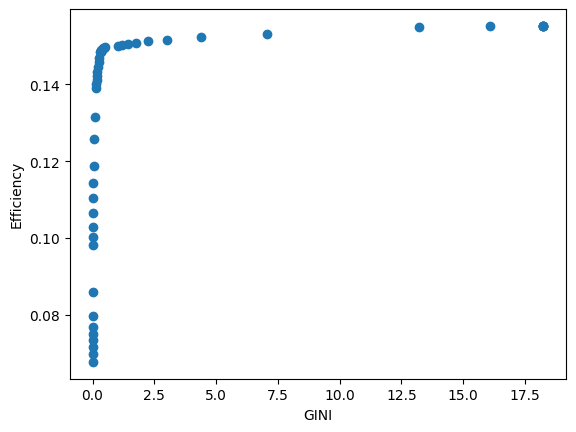

In [324]:
plt.scatter(x_gini, y_eff)
plt.xlabel('GINI')
plt.ylabel('Efficiency')

In [325]:
y_eff[0]


0.15516763046519727

In [341]:
y_eff[-11]

0.14851702286866397

In [327]:
x_gini[9]

0.0010881529160880214

In [342]:
x_gini[-11]

0.3410638345194309

In [279]:
x = np.array([])
x = np.append(x, 1)
x

array([1.])